In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import torch
import torch.nn
import torch.nn.functional as F
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from utils import leave_topk
from conf import settings
device = 'cuda:1'


/home/dt/anaconda3/envs/cv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cifar10_resnet18_pred = pickle.load(open(os.path.join(settings.RESULT_PATH, "model_distance", "cifar10_predict_resnet18.pkl"), "rb"))
cifar100_resnet34_pred = pickle.load(open(os.path.join(settings.RESULT_PATH, "model_distance", "cifar100_predict_resnet34.pkl"), "rb"))
tinyimagenet_resnet152_pred = pickle.load(
    open(os.path.join(settings.RESULT_PATH, "model_distance", "tinyimagenet_predict_resnet152.pkl"), "rb"))


# Influcence of architecture on estimation accuracy 

In [3]:
topk=None

In [4]:
def get_ablation_stat_heatmap(archi1_pred, archi2_pred, epoch, topk=None):
    vic_mean = archi1_pred['vic'].mean(dim=0)
    
    if topk is not None:
        vic_mean = leave_topk(vic_mean, k=topk)

    heat_matrix = [np.zeros((11, 11)) for _ in range(10)]
    inters = list(np.arange(11)/10)
    for i, inter_target in enumerate(inters):
        int_mean = archi1_pred['int{}'.format(inter_target)]
        if topk is not None:
            for a in range(len(int_mean)):
                int_mean[a] = leave_topk(int_mean[a], k=topk)
        dist_mean = torch.sum((int_mean - vic_mean.unsqueeze(0).expand(
                10, vic_mean.shape[0], vic_mean.shape[1]))**2, dim=2).mean(dim=0).cpu().numpy()[0:100]
        
        for j, inter_test in enumerate(inters):
            for k in range(10):
                int_test = archi2_pred['int_{}'.format(inter_test)]['copy_{}'.format(k)][epoch]

                if topk is not None:
                    int_test = leave_topk(int_test, k=topk)
                dist_test = torch.sum((int_test - vic_mean)**2, dim=1).cpu().numpy()[0:100]
                stats, pv = sps.ttest_ind(dist_mean, dist_test)
                heat_matrix[k][j][i] = np.abs(stats)
    return heat_matrix

# Impact of learning rate

In [5]:
comp_lrs = [0.1, 0.05, 0.01]
epoch_strategy = {
    0.01: [100, 200, 200],
    0.05: [100, 200, 200],
    0.1: [100, 200, 200]
}

In [9]:
heatmap_dict = {'CIFAR-10':{}, 'CIFAR-100':{}, 'Tiny-ImageNet':{}}
for comp_lr in comp_lrs:
    
    ablation_cifar10_pred = pickle.load(open(os.path.join(settings.RESULT_PATH, "model_distance", f"cifar10_predict_ablation_{comp_lr}.pkl"), "rb"))
    heatmap_dict['CIFAR-10'][comp_lr] = get_ablation_stat_heatmap(cifar10_resnet18_pred, 
                                                ablation_cifar10_pred, 
                                                epoch=epoch_strategy[comp_lr][0], topk=topk)

    ablation_cifar100_pred = pickle.load(open(os.path.join(settings.RESULT_PATH, "model_distance", f"cifar100_predict_ablation_{comp_lr}.pkl"), "rb"))
    heatmap_dict['CIFAR-100'][comp_lr] = get_ablation_stat_heatmap(cifar100_resnet34_pred, 
                                                 ablation_cifar100_pred, 
                                                 epoch=epoch_strategy[comp_lr][1], topk=topk)

    ablation_tinyimagenet_pred = pickle.load(open(os.path.join(settings.RESULT_PATH, "model_distance", f"tinyimagenet_predict_ablation_{comp_lr}.pkl"), "rb"))
    heatmap_dict['Tiny-ImageNet'][comp_lr] = get_ablation_stat_heatmap(tinyimagenet_resnet152_pred, 
                                                    ablation_tinyimagenet_pred, 
                                                    epoch=epoch_strategy[comp_lr][2], topk=topk)

In [10]:
cifar10_dfdict = {'ModelID':[], 'Mu':[], 'Eps':[], 'Learning Rate':[]}

for comp_lr, hm_dict in heatmap_dict['CIFAR-10'].items():
    for k in range(10):
        dist = np.abs(hm_dict[k].argmin(axis=0) - np.arange(0, 11))
        for m in range(10, 50, 5):
            cifar10_dfdict['Mu'].append(m/100)
            cifar10_dfdict['Eps'].append((dist>=(m/10)).astype(np.int32).mean())
            cifar10_dfdict['ModelID'].append(k)
            cifar10_dfdict['Learning Rate'].append(comp_lr)

In [11]:
cifar100_dfdict = {'ModelID':[], 'Mu':[], 'Eps':[], 'Learning Rate':[]}

for comp_lr, hm_dict in heatmap_dict['CIFAR-100'].items():
    for k in range(10):
        dist = np.abs(hm_dict[k].argmin(axis=0) - np.arange(0, 11))
        for m in range(10, 50, 5):
            cifar100_dfdict['Mu'].append(m/100)
            cifar100_dfdict['Eps'].append((dist>=(m/10)).astype(np.int32).mean())
            cifar100_dfdict['ModelID'].append(k)
            cifar100_dfdict['Learning Rate'].append(comp_lr)

In [12]:

tinyimagenet_dfdict = {'ModelID':[], 'Mu':[], 'Eps':[], 'Learning Rate':[]}
for comp_lr, hm_dict in heatmap_dict['Tiny-ImageNet'].items():
    for k in range(10):
        dist = np.abs(hm_dict[k].argmin(axis=0) - np.arange(0, 11))
        for m in range(10, 50, 5):
            tinyimagenet_dfdict['Mu'].append(m/100)
            tinyimagenet_dfdict['Eps'].append((dist>=(m/10)).astype(np.int32).mean())
            tinyimagenet_dfdict['ModelID'].append(k)
            tinyimagenet_dfdict['Learning Rate'].append(comp_lr)

In [13]:
cifar10_df = pd.DataFrame.from_dict(cifar10_dfdict)
cifar100_df = pd.DataFrame.from_dict(cifar100_dfdict)
tinyimagenet_df = pd.DataFrame.from_dict(tinyimagenet_dfdict)

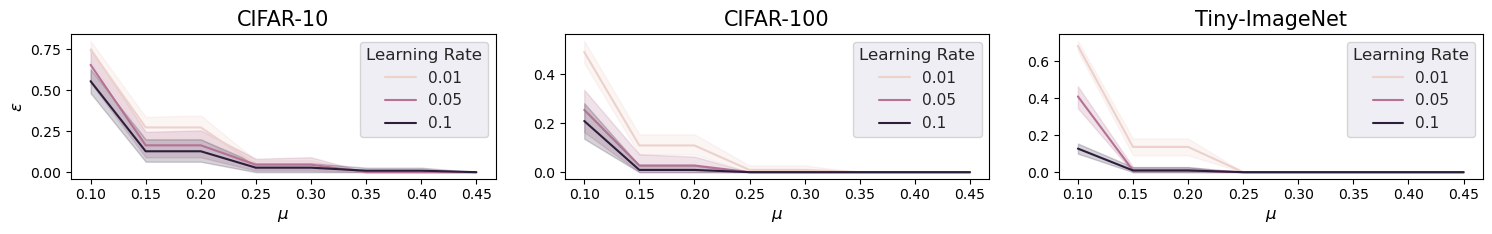

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 2.5)
sns.set_theme(style="darkgrid")
sns.lineplot(x='Mu', y='Eps', hue='Learning Rate', data=cifar10_df, ax=ax1)
ax1.set_ylabel("$\epsilon$", fontsize=12)
ax1.set_xlabel("$\mu$", fontsize=12)
ax1.set_title("CIFAR-10", fontsize=15)

sns.lineplot(x='Mu', y='Eps', hue='Learning Rate', data=cifar100_df, ax=ax2)
ax2.set_ylabel("  ")
ax2.set_xlabel("$\mu$", fontsize=12)
ax2.set_title("CIFAR-100", fontsize=15)

sns.lineplot(x='Mu', y='Eps', hue='Learning Rate', data=tinyimagenet_df, ax=ax3)
ax3.set_ylabel("  ")
ax3.set_xlabel("$\mu$", fontsize=12)
ax3.set_title("Tiny-ImageNet", fontsize=15)
plt.tight_layout()
plt.savefig('estimation_accuracy_ablation_comp_lr{}.pdf'.format('' if topk is None else '_{}'.format(topk)), bbox_inches='tight')
plt.show()

# Impact of training epoch

In [15]:
scales = [0.7, 1.0, 1.5]
lr_strategy = {
    0.7: [0.1, 0.1, 0.1],
    1.0: [0.1, 0.1, 0.1],
    1.5: [0.1, 0.1, 0.1]
}

In [16]:
heatmap_dict = {'CIFAR-10':{}, 'CIFAR-100':{}, 'Tiny-ImageNet':{}}
for scale in scales:
    comp_lr = lr_strategy[scale][0]
    ablation_cifar10_pred = pickle.load(open(os.path.join(settings.RESULT_PATH, "model_distance", f"cifar10_predict_ablation_{comp_lr}.pkl"), "rb"))
    heatmap_dict['CIFAR-10'][scale] = get_ablation_stat_heatmap(cifar10_resnet18_pred, 
                                                ablation_cifar10_pred, 
                                                epoch=int(scale * 100), topk=topk)
    comp_lr = lr_strategy[scale][1]
    ablation_cifar100_pred = pickle.load(open(os.path.join(settings.RESULT_PATH, "model_distance", f"cifar100_predict_ablation_{comp_lr}.pkl"), "rb"))
    heatmap_dict['CIFAR-100'][scale] = get_ablation_stat_heatmap(cifar100_resnet34_pred, 
                                                 ablation_cifar100_pred, 
                                                 epoch=int(scale * 200), topk=topk)
    comp_lr = lr_strategy[scale][2]
    ablation_tinyimagenet_pred = pickle.load(open(os.path.join(settings.RESULT_PATH, "model_distance", f"tinyimagenet_predict_ablation_{comp_lr}.pkl"), "rb"))
    heatmap_dict['Tiny-ImageNet'][scale] = get_ablation_stat_heatmap(tinyimagenet_resnet152_pred, 
                                                    ablation_tinyimagenet_pred, 
                                                    epoch=int(scale * 200), topk=topk)

In [17]:
cifar10_dfdict = {'ModelID':[], 'Mu':[], 'Eps':[], 'Epoch Scale':[]}

for scale, hm_dict in heatmap_dict['CIFAR-10'].items():
    for k in range(10):
        dist = np.abs(hm_dict[k].argmin(axis=0) - np.arange(0, 11))
        for m in range(10, 50, 5):
            cifar10_dfdict['Mu'].append(m/100)
            cifar10_dfdict['Eps'].append((dist>=(m/10)).astype(np.int32).mean())
            cifar10_dfdict['ModelID'].append(k)
            cifar10_dfdict['Epoch Scale'].append(scale)

In [18]:
cifar100_dfdict = {'ModelID':[], 'Mu':[], 'Eps':[], 'Epoch Scale':[]}

for scale, hm_dict in heatmap_dict['CIFAR-100'].items():
    for k in range(10):
        dist = np.abs(hm_dict[k].argmin(axis=0) - np.arange(0, 11))
        for m in range(10, 50, 5):
            cifar100_dfdict['Mu'].append(m/100)
            cifar100_dfdict['Eps'].append((dist>=(m/10)).astype(np.int32).mean())
            cifar100_dfdict['ModelID'].append(k)
            cifar100_dfdict['Epoch Scale'].append(scale)

In [19]:

tinyimagenet_dfdict = {'ModelID':[], 'Mu':[], 'Eps':[], 'Epoch Scale':[]}
for scale, hm_dict in heatmap_dict['Tiny-ImageNet'].items():
    for k in range(10):
        dist = np.abs(hm_dict[k].argmin(axis=0) - np.arange(0, 11))
        for m in range(10, 50, 5):
            tinyimagenet_dfdict['Mu'].append(m/100)
            tinyimagenet_dfdict['Eps'].append((dist>=(m/10)).astype(np.int32).mean())
            tinyimagenet_dfdict['ModelID'].append(k)
            tinyimagenet_dfdict['Epoch Scale'].append(scale)

In [20]:
cifar10_df = pd.DataFrame.from_dict(cifar10_dfdict)
cifar100_df = pd.DataFrame.from_dict(cifar100_dfdict)
tinyimagenet_df = pd.DataFrame.from_dict(tinyimagenet_dfdict)

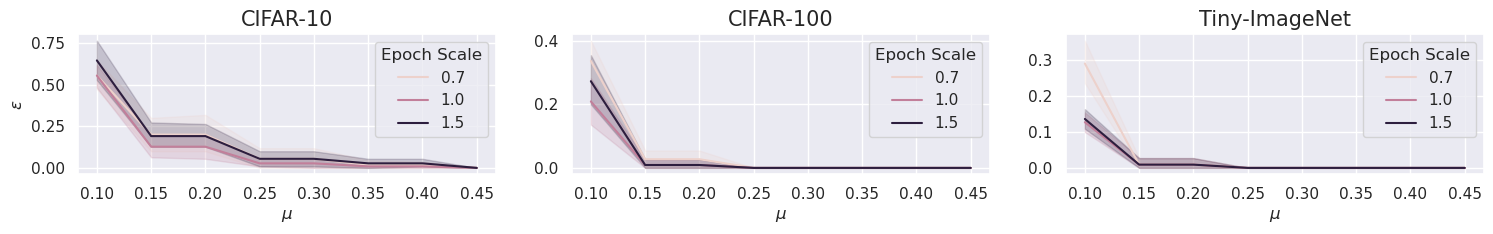

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
fig.set_size_inches(15, 2.5)
sns.set_theme(style="darkgrid")
sns.lineplot(x='Mu', y='Eps', hue='Epoch Scale', data=cifar10_df, ax=ax1)
ax1.set_ylabel("$\epsilon$", fontsize=12)
ax1.set_xlabel("$\mu$", fontsize=12)
ax1.set_title("CIFAR-10", fontsize=15)

sns.lineplot(x='Mu', y='Eps', hue='Epoch Scale', data=cifar100_df, ax=ax2)
ax2.set_ylabel("  ")
ax2.set_xlabel("$\mu$", fontsize=12)
ax2.set_title("CIFAR-100", fontsize=15)

sns.lineplot(x='Mu', y='Eps', hue='Epoch Scale', data=tinyimagenet_df, ax=ax3)
ax3.set_ylabel("  ")
ax3.set_xlabel("$\mu$", fontsize=12)
ax3.set_title("Tiny-ImageNet", fontsize=15)
plt.tight_layout()
plt.savefig('estimation_accuracy_ablation_comp_epoch_scale{}.pdf'.format('' if topk is None else '_{}'.format(topk)), bbox_inches='tight')
plt.show()